In [3]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import OrderedDict

# Two Layer Net

## load mnist

In [7]:
def load_mnist(normalize=True, flatten=True, one_hot_label=False):
    def _change_one_hot_label(X):
        T = np.zeros((X.size, 10))
        for idx, row in enumerate(T):
            row[X[idx]] = 1

        return T

    with open('dataset/mnist.pkl', 'rb') as f:
        dataset = pickle.load(f)
        
    if normalize:
        for key in ('train_img', 'test_img'):
            dataset[key] = dataset[key].astype(np.float32)
            dataset[key] /= 255.0
            
    if one_hot_label:
        dataset['train_label'] = _change_one_hot_label(dataset['train_label'])
        dataset['test_label'] = _change_one_hot_label(dataset['test_label'])    
    
    if not flatten:
         for key in ('train_img', 'test_img'):
            dataset[key] = dataset[key].reshape(-1, 1, 28, 28)

    return (dataset['train_img'], dataset['train_label']), (dataset['test_img'], dataset['test_label']) 

## Softmax

In [17]:
def softmax(x):
    exp_x = np.exp(x)
    if exp_x.ndim == 1:
        sum_exp_x = np.sum(exp_x)
    else:
        sum_exp_x = np.sum(exp_x, axis=1).reshape(-1, 1)
    y = exp_x/sum_exp_x
    return y


## Cross entropy error

In [22]:
###
def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1,t.size)
        y = y.reshape(1,y.size)
    
    batch_size = y.shape[0]

    delta = 1e-7
    return -np.sum(t*np.log(y+delta))/batch_size

In [19]:
### minibatch
def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)

    
    batch_size = y.shape[0]
    
    delta = 1e-7
    return -np.sum(np.log(y[np.arange(batch_size), t] + delta))/batch_size

## Relu

In [10]:
class Relu:
    def __init__(self):
        self.mask = None

    def forward(self, x):
        # 강사님은 self 안 하셨음
        # 0이였냐 아니였냐를 기억해야하므로 mask 를 다 self 를 붙여준다.
        self.mask = (x <= 0)
        out = x.copy()
        out[self.mask] = 0

        return out

    def backward(self, dout):
        dout[self.mask] = 0
        return dout

## Affine

In [11]:
class Affine:
    def __init__(self, W, b):
        self.W = W
        self.b = b
        
        self.x = None
        self.dW = None
        self.db = None

    def forward(self, x):
        self.x = x
        out = np.dot(self.x, self.W) + self.b

        return out

    def backward(self, dout):
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis=0)
        return dx


## Softmax With Loss

In [12]:
class SoftmaxWithLoss:
    def __init__(self):
        self.loss = None # 손실함수
        self.y = None    # softmax의 출력
        self.t = None    # 정답 레이블(원-핫 인코딩 형태)
        
    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy_error(self.y, self.t)
        
        return self.loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]
        ## 원핫 인코딩 상태랑 합하면 1 그리고 원핫 인코딩이 아닐떄는 그냥 1을 빼준다는 의미인데 다시 생각해보자
        if self.t.size == self.y.size: # 정답 레이블이 원-핫 인코딩 형태일 때
            dx = (self.y - self.t) / batch_size
        else:
            dx = self.y.copy()
            dx[np.arange(batch_size), self.t] -= 1
            dx = dx / batch_size
        
        return dx

# -----

In [13]:
class TwoLayerNet:

    def __init__(self, input_size, hidden_size, output_size, weight_init_std = 0.01):
        # 가중치 초기화
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size) 
        self.params['b2'] = np.zeros(output_size)
    
        # 계층 생성 레이어를 만들어줄거임. OrederdDict()는 순서가 있는 Dict 집어넣는 순서가 있음. 순서가 중요함
        # 입력층을 거치고 히든레이어를 거치고 또 거치고 순서대로 가야하기 때문에 순서가 중요함.
        self.layers = OrderedDict()
        self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
        self.layers['Relu1'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])

        self.lastLayer = SoftmaxWithLoss()
        
    def predict(self, x):
        # 이것때문에 OrderedDict 를 만든것이다.
        # 원래같았으면
        # x = self.layers['Affine1'].forward(x)
        # x = self.layers['Relu1'].forward(x)
        # x = self.layers['Affine2'].forward(x)
        # return x

        ########## 바꾼것 ##################
        for layer in self.layers.values():
            x = layer.forward(x)
        
        return x
        ##################################
        
    # x : 입력 데이터, t : 정답 레이블
    def loss(self, x, t):
        y = self.predict(x)
        return self.lastLayer.forward(y, t)
    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        if t.ndim != 1 : 
            t = np.argmax(t, axis=1)
        
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
        
    # x : 입력 데이터, t : 정답 레이블
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)
        
        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        
        return grads
        
    def gradient(self, x, t):
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.lastLayer.backward(dout)
        
        layers = list(self.layers.values())
        #거꾸로 거슬러 올라가야하기때문에 리스르로 바꿔주고 리버스 해줬음.
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 결과 저장
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W2'], grads['b2'] = self.layers['Affine2'].dW, self.layers['Affine2'].db

        return grads


In [14]:
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

In [15]:
iters_num = 10000  # 반복 횟수를 적절히 설정한다.
train_size = x_train.shape[0]
batch_size = 100  # 미니배치 크기
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []

# 1에폭당 반복 수
iter_per_epoch = max(train_size / batch_size, 1)

train acc, test acc | 0.125, 0.1298
train acc, test acc | 0.9030166666666667, 0.9043
train acc, test acc | 0.92165, 0.924
train acc, test acc | 0.9335666666666667, 0.9352
train acc, test acc | 0.9421, 0.9429
train acc, test acc | 0.9510833333333333, 0.9505
train acc, test acc | 0.9543, 0.9507
train acc, test acc | 0.9588333333333333, 0.9587
train acc, test acc | 0.9634, 0.9595
train acc, test acc | 0.9669, 0.9613
train acc, test acc | 0.9700833333333333, 0.9638
train acc, test acc | 0.97115, 0.964
train acc, test acc | 0.9737833333333333, 0.965
train acc, test acc | 0.9751, 0.9668
train acc, test acc | 0.97475, 0.9668
train acc, test acc | 0.97775, 0.9684
train acc, test acc | 0.9791, 0.9667


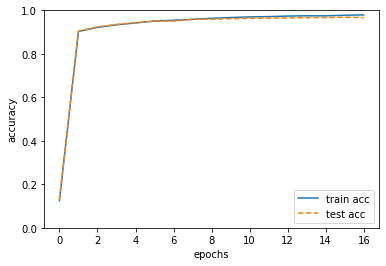

In [23]:
for i in range(iters_num):
    # 미니배치 획득
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    # 기울기 계산
    # numerical_gradient 랑 비교해볼것
    grad = network.gradient(x_batch, t_batch)

    # 매개변수 갱신
    for key in ("W1", "b1", "W2", "b2"):
        network.params[key] -= learning_rate * grad[key]

    # 학습 경과 기록
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)

    # 1에폭당 정확도 계산
    # i 가 10000 이였고 batch 가 100 이였음 그래서 100번마다 찍어본다?
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print("train acc, test acc | " + str(train_acc) + ", " + str(test_acc))

# 그래프 그리기
markers = {"train": "o", "test": "s"}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, label="train acc")
plt.plot(x, test_acc_list, label="test acc", linestyle="--")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc="lower right")
plt.show()
